In [2]:
import os
import anndata as ad
import umap
import scipy as sip
from scipy import sparse
from sklearn import preprocessing
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from sklearn.metrics import adjusted_mutual_info_score as ami
from snf import compute, metrics
import matplotlib.pyplot as plt
from collections import Counter
import math
import itertools

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-usin

In [3]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

complementary = os.path.join(input, "complementary")

shared = os.path.join(output, "shared_info_74")


level1 = os.path.join(output, "level1")
level2 = os.path.join(output, "level2")
level4 = os.path.join(output, "level4")
level3_concat = os.path.join(output, "level3_concat")
level3_snf = os.path.join(output, "level3_snf")

In [4]:
with open(os.path.join(level1, "graphs_74.pickle"), "rb") as f:
    level1_graphs = pickle.load(f) 
with open(os.path.join(level2, "graphs_74.pickle"), "rb") as f:
    level2_graphs = pickle.load(f) 
with open(os.path.join(level3_concat, "graphs_74.pickle"), "rb") as f:
    level3_concat_graphs = pickle.load(f) 
with open(os.path.join(level4, "graphs_74.pickle"), "rb") as f:
    level4_graphs = pickle.load(f) 

In [5]:
with open(os.path.join(level1, "feature_matrices.pickle"), "rb") as f:
    level1_fm = pickle.load(f) 
with open(os.path.join(level2, "feature_matrices.pickle"), "rb") as f:
    level2_fm = pickle.load(f) 
with open(os.path.join(level3_concat, "feature_matrices.pickle"), "rb") as f:
    level3_concat_fm = pickle.load(f) 
with open(os.path.join(level4, "feature_matrices.pickle"), "rb") as f:
    level4_fm = pickle.load(f)

In [6]:
with open(os.path.join(shared, "patients_74.pickle"), "rb") as f:
    patients_74 = pickle.load(f) 

with open(os.path.join(complementary, "module_name_to_id.pickle"), "rb") as f:
    module_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "id_to_module_name.pickle"), "rb") as f:
    id_to_module_name = pickle.load(f) 

with open(os.path.join(shared, "id_to_modality.pickle"), "rb") as f:
    id_to_modality = pickle.load(f) 
with open(os.path.join(shared, "modality_to_id.pickle"), "rb") as f:
    modality_to_id = pickle.load(f) 

with open(os.path.join(shared, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(shared, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 

with open(os.path.join(level1, "noise_graphs_74.pickle"), "rb") as f:
    noise_74 = pickle.load(f) 

with open(os.path.join(shared, "noise_name_to_id.pickle"), "rb") as f:
    noise_name_to_id = pickle.load(f) 
with open(os.path.join(shared, "noise_id_to_name.pickle"), "rb") as f:
    noise_id_to_name = pickle.load(f) 

with open(os.path.join(shared, "ground_truth_d.pickle"), "rb") as f:
    gt_d = pickle.load(f) 
with open(os.path.join(shared, "ground_truth_dg.pickle"), "rb") as f:
    gt_dg = pickle.load(f) 

In [7]:
diseases = list(level1_graphs["G0"].obs.Disease.unique())
disease_groups = list(level1_graphs["G0"].obs.DiseaseGroup.unique())

with open(os.path.join(shared, 'diseases.pickle'), 'wb') as f:
        pickle.dump(diseases, f)

with open(os.path.join(shared, 'disease_groups.pickle'), 'wb') as f:
        pickle.dump(disease_groups, f)

In [8]:
# For every modality, extract the set of graphs belonging to it
citeRNA_g_with_74 = {}
bulkRNA_g_with_74 = {}
luminex_g_with_74 = {}
cytof_g_with_74 = {}
adt_g_with_74 = {}
facs_g_with_74 = {}
for id, g in level1_graphs.items():
    modality = g.uns["modality"]
    if modality == "citeRNA":
        citeRNA_g_with_74[id] = g
    elif modality == "bulkRNA":
        bulkRNA_g_with_74[id] = g
    elif modality == "cytof":
        cytof_g_with_74[id] = g
    elif modality == "luminex":
        luminex_g_with_74[id] = g
    elif modality == "facs":
        facs_g_with_74[id] = g
    elif modality == "adt":
        adt_g_with_74[id] = g

In [9]:
interesting_patients = [
"S00027-Ja003",
"S00033-Ja003",
"S00033-Ja005",
"S00068-Ja005",
"S00095-Ja005",
"S00065-Ja003",
"S00005-Ja005",
"S00040-Ja005",
"S00119-Ja003",
"S00020-Ja003"]
interesting_patients = set([p.split("-")[0] for p in interesting_patients]) # Extract ids, remove duplicates
interesting_patients = list(set(patients_74).intersection(interesting_patients))


healthy_patients = [p for p in list(level1_graphs["G0"].obs_names) if level1_graphs["G0"][p].obs.Disease[0] == "HV"]


palette = ig.RainbowPalette(n=7)
disease_color_map = {diseases[i]:palette[i] for i in range(6)}
palette = ig.RainbowPalette(n=3)
disease_group_color_map = {disease_groups[i]:palette[i] for i in range(3)}

In [10]:
panelize_reward_d = []
panelize_reward_dg = []

for i in patients_74:
    panelize_reward_d_ij = []
    panelize_reward_dg_ij = []

    d1 = level1_graphs["G0"][i].obs.Disease[0]
    dg1 = level1_graphs["G0"][i].obs.DiseaseGroup[0]

    for j in patients_74:
        d2 = level1_graphs["G0"][j].obs.Disease[0]
        dg2 = level1_graphs["G0"][j].obs.DiseaseGroup[0]

        if d1 == d2:
            panelize_reward_d_ij.append(1)
        else:
            panelize_reward_d_ij.append(-1)
        """elif dg1 == dg2:
            p_d_ij.append(0.5)
        elif d1 == "HV" or d2 == "HV":
            p_d_ij.append(-1)
        else:
            p_d_ij.append(-0.5)"""

        if dg1 == dg2:
            panelize_reward_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            panelize_reward_dg_ij.append(-2)
        else:
            panelize_reward_dg_ij.append(-1)

    panelize_reward_d.append(panelize_reward_d_ij)
    panelize_reward_dg.append(panelize_reward_dg_ij)


for i in range(len(panelize_reward_dg)):
    panelize_reward_d[i][i] = 0
    panelize_reward_dg[i][i] = 0

panelize_reward_d = np.array(panelize_reward_d, dtype="float64")
panelize_reward_dg = np.array(panelize_reward_dg, dtype="float64")

In [11]:
optimal_graph = []
for i, dg1 in enumerate(list(level1_graphs["G0"].obs.DiseaseGroup)):
    neighbors_of_i = []
    for j, dg2 in enumerate(list(level1_graphs["G0"].obs.DiseaseGroup)):
        if i == j or dg1 != dg2:
            neighbors_of_i.append(0)
        else:
            neighbors_of_i.append(1)
    optimal_graph.append(neighbors_of_i)
    
optimal_graph = np.array(optimal_graph, dtype = "float64")
print(optimal_graph)

optimal_rw_score = 74

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [12]:
modality_frequency_weights = {"citeRNA": 1/209, "bulkRNA": 1/12, "adt": 1/11, "facs": 1, "luminex": 1, "cytof": 1/12 }
modality_frequency_weights  = {id: modality_frequency_weights[g.uns["modality"]] * 1/ 6 for id, g in level1_graphs.items()}
weighted_avg_weights = {id: 1/len(level1_graphs)  for id, g in level1_graphs.items()}

## Functions

In [13]:
def make_transition_matrix(fused_network):
    tm = []
    for i, row in enumerate(fused_network):
        tm.append(row/ sum(row))
    return tm

def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * panelize_reward_d).sum()
    dg_score = (transition_matrix * panelize_reward_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return d_score, dg_score, score

def adjust_weights(psns, scale_weights = modality_frequency_weights):
    adjusted_weights = {}
    for id, psn in psns.items():
        adjusted_weights[id] = psn * modality_frequency_weights[id]
    return adjusted_weights

In [14]:
def knn(g, k, metric): # g is an AnnData Object
    scp.pp.neighbors(g, n_neighbors = k, use_rep='X', metric =  metric) 
    return np.array(sparse.csr_matrix.todense(g.obsp["connectivities"]), dtype = "float64") # Returns a matrix

def aff(g, metric, k, mu ): # g is a list of matrices 
    return compute.make_affinity(g, metric=metric, K=k, mu=mu, normalize = False)  # Returns a list of matrices

# Optimization

## Optimizing PSNs

In [15]:
setup_knn_pr = {}
setup_knn_s = {}
setup_knn_db = {}

ks = [4,5,6,7,8]
metrics = ["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "chebyshev", "canberra"]
combinations = set(itertools.product(ks, metrics))

for i, combi in enumerate(combinations):
    print(str(i), "/", str(len(combinations)))
    try:
        k = combi[0]
        metric = combi[1]
        graphs = {}
        fused = None
        for id, g in level1_graphs.items():
            weight = modality_frequency_weights[id]
            graphs[id] = knn(g, k, metric)
            
            if fused is None:
                fused = weight * graphs[id]
            else:
                fused = weight * graphs[id] + fused
            
       
        transition = make_transition_matrix(fused)
        pr_score = random_walker_objective(transition)[2]

        ad_obj = ad.AnnData(fused)
        ad_obj.obsp['connectivities'] = fused
        scp.tl.leiden(ad_obj, resolution=1, key_added='leiden', adjacency=fused, directed=False, use_weights=True)
        l = list(ad_obj.obs.leiden)

        s_score = skl.metrics.silhouette_score(fused, l)
        db_score = skl.metrics.davies_bouldin_score(fused, l)
   
    
        print("success")
        setup_knn_pr[pr_score] = {"k":k, "metric": metric}
        setup_knn_s[s_score] = {"k":k, "metric": metric}
        setup_knn_db[db_score] = {"k":k, "metric": metric}

    except np.linalg.LinAlgError:
        print(i, "fail")
        continue
    except BaseException:
        print(i, "fail")
        continue

0 / 40


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: 

success
1 / 40
success
2 / 40
success
3 / 40
success
4 / 40
success
5 / 40
success
6 / 40
success
7 / 40
success
8 / 40
success
9 / 40
success
10 / 40
success
11 / 40
success
12 / 40
success
13 / 40
success
14 / 40
success
15 / 40
success
16 / 40
success
17 / 40
success
18 / 40
success
19 / 40
success
20 / 40
success
21 / 40
success
22 / 40
success
23 / 40
success
24 / 40
success
25 / 40
success
26 / 40
success
27 / 40
success
28 / 40
success
29 / 40
success
30 / 40
success
31 / 40
success
32 / 40
success
33 / 40
success
34 / 40
success
35 / 40
success
36 / 40
success
37 / 40
success
38 / 40
success
39 / 40
success


In [16]:
# no self-loop remove, t = 40, grid search, update hpp

In [17]:
setup_knn_pr = {k: v for k, v in sorted(setup_knn_pr.items(), key=lambda item: item[0])} # sort according to scores
best_knn_pr = setup_knn_pr[list(setup_knn_pr.keys())[-1]]
setup_knn_s = {k: v for k, v in sorted(setup_knn_s.items(), key=lambda item: item[0])} 
best_knn_s = setup_knn_s[list(setup_knn_s.keys())[-1]]
setup_knn_db = {k: v for k, v in sorted(setup_knn_db.items(), key=lambda item: item[0])} 
best_knn_db = setup_knn_db[list(setup_knn_db.keys())[0]]

print(best_knn_pr, best_knn_s, best_knn_db)

{'k': 4, 'metric': 'correlation'} {'k': 8, 'metric': 'correlation'} {'k': 8, 'metric': 'correlation'}


In [15]:
#best_knn = {'k': 4, 'metric': 'correlation'}
best_knn = {'k': 7, 'metric': 'correlation'}

In [19]:
setup_kernel_pr = {}
setup_kernel_s = {}
setup_kernel_db = {}

ks = [4,5,6,7,8]
metrics = ["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "mahalanobis", "chebyshev", "canberra"]
mus = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

combinations = set(itertools.product(ks, metrics, mus))

for i, combi in enumerate(combinations):
    print(str(i), "/", str(len(combinations)))
    try:
        k = combi[0]
        metric = combi[1]
        mu = combi[2] 
        
        graphs = aff(list(level1_fm.values()), metric, k, mu)
        fused = compute.snf(graphs, K=k, t = 40)

        transition = make_transition_matrix(fused)
        score_pr = random_walker_objective(transition)[2]

        
        first, second = compute.get_n_clusters(fused)
        l = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

        score_s = skl.metrics.silhouette_score(fused, l)
        score_db = skl.metrics.davies_bouldin_score(fused, l)

        print("success")
        setup_kernel_pr[score_pr] = {"k":k, "metric": metric, "mu": mu}
        setup_kernel_s[score_s] = {"k":k, "metric": metric, "mu": mu}
        setup_kernel_db[score_db] = {"k":k, "metric": metric, "mu": mu}
        
    except ValueError:
        print(i, "fail")
        continue

0 / 315
success
1 / 315
success
2 / 315
2 fail
3 / 315
success
4 / 315
success
5 / 315
success
6 / 315
success
7 / 315
success
8 / 315
8 fail
9 / 315
9 fail
10 / 315
success
11 / 315
11 fail
12 / 315
success
13 / 315
success
14 / 315
success
15 / 315
success
16 / 315
16 fail
17 / 315
17 fail
18 / 315
success
19 / 315
success
20 / 315
success
21 / 315
success
22 / 315
success
23 / 315
23 fail
24 / 315
24 fail
25 / 315
success
26 / 315
success
27 / 315
success
28 / 315
success
29 / 315
success
30 / 315
success
31 / 315
success
32 / 315
success
33 / 315
success
34 / 315
34 fail
35 / 315
success
36 / 315
success
37 / 315
success
38 / 315
success
39 / 315
39 fail
40 / 315
success
41 / 315
success
42 / 315
42 fail
43 / 315
success
44 / 315
success
45 / 315
success
46 / 315
success
47 / 315
success
48 / 315
48 fail
49 / 315
success
50 / 315
success
51 / 315
51 fail
52 / 315
success
53 / 315
53 fail
54 / 315
success
55 / 315
success
56 / 315
56 fail
57 / 315
success
58 / 315
success
59 / 315
s

In [20]:
setup_kernel_pr = {k: v for k, v in sorted(setup_kernel_pr.items(), key=lambda item: item[0])} # sort according to scores
best_kernel_pr = setup_kernel_pr[list(setup_kernel_pr.keys())[-1]]
setup_kernel_s = {k: v for k, v in sorted(setup_kernel_s.items(), key=lambda item: item[0])} 
best_kernel_s = setup_kernel_s[list(setup_kernel_s.keys())[-1]]
setup_kernel_db = {k: v for k, v in sorted(setup_kernel_db.items(), key=lambda item: item[0])} 
best_kernel_db = setup_kernel_db[list(setup_kernel_db.keys())[0]]
print(best_kernel_pr,best_kernel_s, best_kernel_db )

{'k': 8, 'metric': 'sqeuclidean', 'mu': 0.3} {'k': 4, 'metric': 'correlation', 'mu': 0.4} {'k': 5, 'metric': 'chebyshev', 'mu': 0.2}


In [16]:
best_kernel = {'k': 7, 'metric': 'sqeuclidean', 'mu': 0.3}

# Level1

In [17]:
level1_knn_psns = {}
for id, g in level1_graphs.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    level1_knn_psns[id] = graph

noise_knn_psns = {}
for id, g in noise_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    noise_knn_psns[id] = graph

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: 

In [23]:
level1_kernel_psns = {}
graphs = compute.make_affinity(list(level1_fm.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(level1_graphs.keys()):
    level1_kernel_psns[id] = graphs[i]

noise_kernel_psns = {}
graphs_noise = [g.X for g in noise_74.values()]
graphs_noise = compute.make_affinity(graphs_noise, metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(noise_74.keys()):
    noise_kernel_psns[id] = graphs_noise[i]

In [24]:
level1_correlations = {}
for id, ad_obj in level1_graphs.items():
    level1_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

noise_correlations = {}
for id, ad_obj in noise_74.items():
    noise_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

In [25]:
for id in noise_kernel_psns.keys():
    np.random.shuffle(noise_kernel_psns[id])
    np.random.shuffle(noise_knn_psns[id])
    np.random.shuffle(noise_correlations[id])

dict_keys(['adt', 'facs', 'cytof', 'luminex', 'bulkRNA', 'citeRNA'])


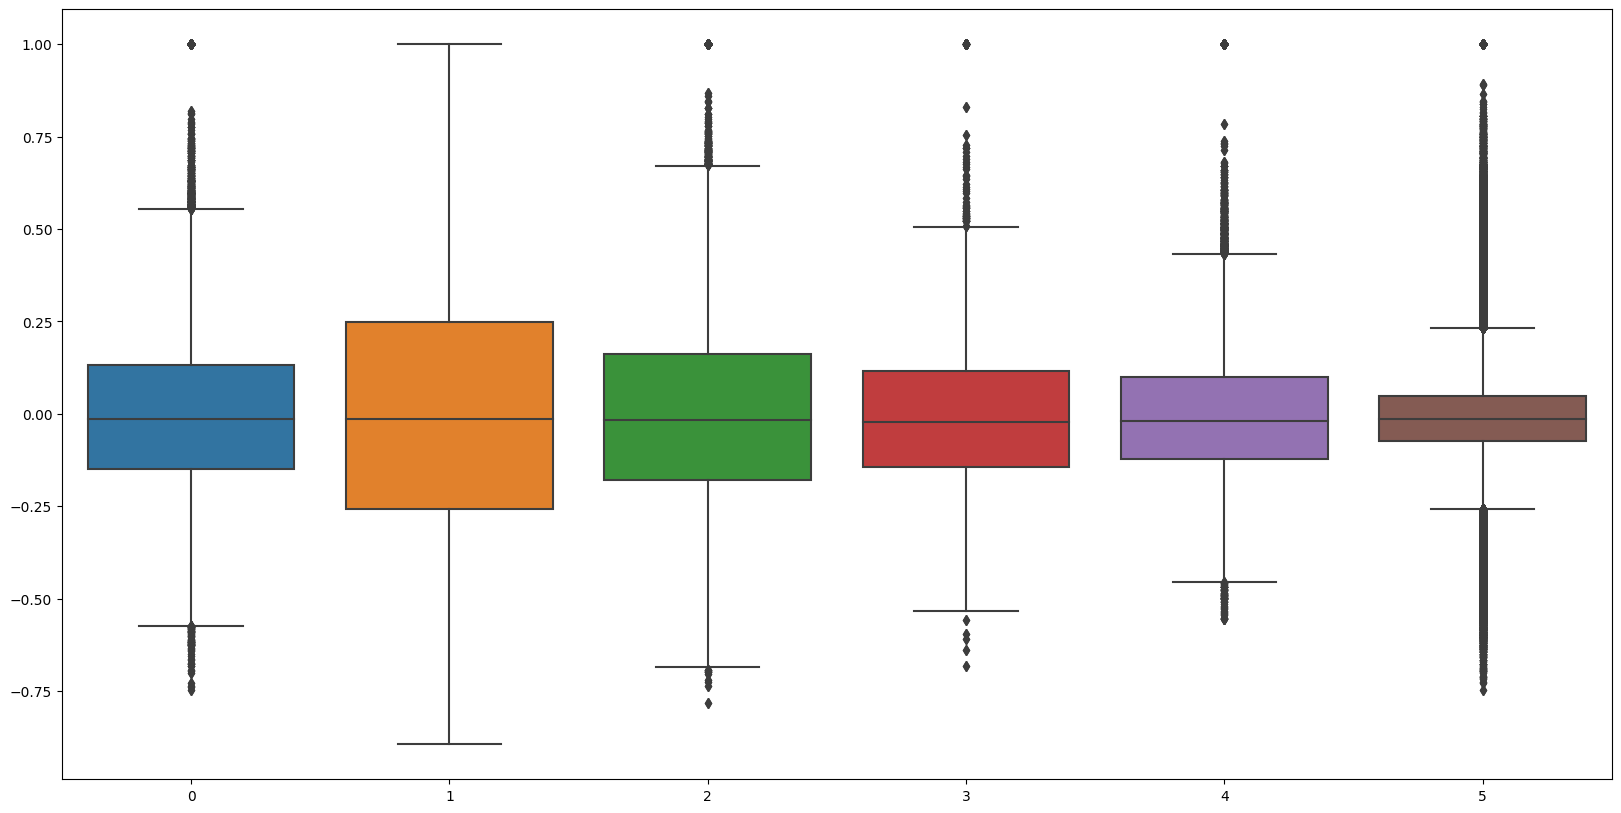

In [26]:
corr_info_per_modality = {m: [] for m in set(id_to_modality.values())}
for id, c in level1_correlations.items():
    m = id_to_modality[id]
    corr_info_per_modality[m] =corr_info_per_modality[m] + (list(c.flatten()))

print(corr_info_per_modality.keys())
fig, ax = plt.subplots(figsize=(20,10))
ax = sb.boxplot(list(corr_info_per_modality.values()), ax = ax )


correlations_original = level1_correlations.copy()
for id, c in level1_correlations.items():
    zeros = np.argwhere(c < 0)
    for z_loc in zeros:
        c[z_loc[0], z_loc[1]] = 0
    level1_correlations[id] = c

In [27]:
with open(os.path.join(level1, 'correlations.pickle'), 'wb') as f:
    pickle.dump(level1_correlations, f)
with open(os.path.join(level1, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(level1_knn_psns, f)
with open(os.path.join(level1, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(level1_kernel_psns, f)


with open(os.path.join(level1, 'noise_correlations.pickle'), 'wb') as f:
    pickle.dump(noise_correlations, f)
with open(os.path.join(level1, 'noise_knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_knn_psns, f)
with open(os.path.join(level1, 'noise_kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_kernel_psns, f)

In [28]:
all_kernel_psns = list(noise_kernel_psns.values()) + list(level1_kernel_psns.values())
all_knn_psns = list(noise_knn_psns.values()) + list(level1_knn_psns.values()) 
all_feature_matrices = [noise.X for noise in noise_74.values()] + list(level1_fm.values()) 
all_correlations = list(noise_correlations.values()) + list(level1_correlations.values())
all_names = list(noise_kernel_psns.keys()) + list(level1_kernel_psns.keys()) 

In [29]:
all_dict = {"knn_psns": all_knn_psns, "kernel_psns": all_kernel_psns, "feature_matrices": all_feature_matrices,  "correlations": all_correlations, "names":all_names}

with open(os.path.join(level1, 'noise_and_none_noise_combined.pickle'), 'wb') as f:
    pickle.dump(all_dict, f)

In [30]:
print("123")
"""labels_corr_psn_sc = {}

for i in range(len(all_names)):
    name = all_names[i] 
    psn = all_correlations[i]
    
    if np.isnan(psn).any():
        nan_locs = np.argwhere(np.isnan(psn))
        for loc in nan_locs:
            psn[loc[0], loc[1]] = 0
        print(np.isnan(psn).any() == False)

    if np.isinf(psn).any():
        inf_locs = np.argwhere(np.isinf(psn))
        for loc in inf_locs:
            psn[loc[0], loc[1]] = 0
        print(np.isinf(psn).any() == False)

    first, second = compute.get_n_clusters(psn)
    labels_sc_corr = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)

    labels_corr_psn_sc[name] = labels_sc_corr"""

123


'labels_corr_psn_sc = {}\n\nfor i in range(len(all_names)):\n    name = all_names[i] \n    psn = all_correlations[i]\n    \n    if np.isnan(psn).any():\n        nan_locs = np.argwhere(np.isnan(psn))\n        for loc in nan_locs:\n            psn[loc[0], loc[1]] = 0\n        print(np.isnan(psn).any() == False)\n\n    if np.isinf(psn).any():\n        inf_locs = np.argwhere(np.isinf(psn))\n        for loc in inf_locs:\n            psn[loc[0], loc[1]] = 0\n        print(np.isinf(psn).any() == False)\n\n    first, second = compute.get_n_clusters(psn)\n    labels_sc_corr = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)\n\n    labels_corr_psn_sc[name] = labels_sc_corr'

# Level2

In [19]:
level2_kernel_psns = {}
graphs = compute.make_affinity(list(level2_fm.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(level2_graphs.keys()):
    level2_kernel_psns[id] = graphs[i]

In [18]:
level2_knn_psns = {}
        
for id, g in level2_graphs.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    level2_knn_psns[id] = graph

In [33]:
level2_correlations = {}
for id, ad_obj in level2_graphs.items():
    level2_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

In [34]:
len(level2_correlations) == len(level2_knn_psns) == len(level2_kernel_psns) == 37

True

In [35]:
with open(os.path.join(level2, 'correlations.pickle'), 'wb') as f:
    pickle.dump(level2_correlations, f)
with open(os.path.join(level2, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(level2_knn_psns, f)
with open(os.path.join(level2, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(level2_kernel_psns, f)

# Level4

In [20]:
level4_kernel_psns = {}
graphs = compute.make_affinity(list(level4_fm.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(level4_graphs.keys()):
    level4_kernel_psns[id] = graphs[i]

In [21]:
level4_knn_psns = {}       
for id, g in level4_graphs.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    level4_knn_psns[id] = graph

In [38]:
level4_correlations = {}
for id, ad_obj in level4_graphs.items():
    level4_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

In [39]:
len(level4_correlations) == len(level4_knn_psns) == len(level4_kernel_psns) == len(level4_fm) == 6

True

In [40]:
with open(os.path.join(level4, 'correlations.pickle'), 'wb') as f:
    pickle.dump(level4_correlations, f)
with open(os.path.join(level4, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(level4_knn_psns, f)
with open(os.path.join(level4, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(level4_kernel_psns, f)

# Level3-concat

In [41]:
level3_concat_kernel_psns = {}
graphs = compute.make_affinity(list(level3_concat_fm.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(level3_concat_graphs.keys()):
    level3_concat_kernel_psns[id] = graphs[i]

In [42]:
level3_concat_knn_psns = {}
        
for id, g in level3_concat_graphs.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    level3_concat_knn_psns[id] = graph

In [43]:
level3_concat_correlations  = {}
for id, ad_obj in level3_concat_graphs.items():
    level3_concat_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

In [44]:
len(level3_concat_correlations) == len(level3_concat_knn_psns) == len(level3_concat_kernel_psns) == len(level3_concat_fm) == 6

True

In [45]:
with open(os.path.join(level3_concat, 'correlations.pickle'), 'wb') as f:
    pickle.dump(level3_concat_correlations, f)
with open(os.path.join(level3_concat, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(level3_concat_knn_psns, f)
with open(os.path.join(level3_concat, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(level3_concat_kernel_psns, f)

# Level3 - SNF

In [46]:
level_3_snf_correlation = {}
level_3_snf_kernel_psns = {}

for mod, ids in modality_to_id.items():
    corr = []
    aff = []
    if mod == "facs" or mod == "luminex":
        corr = level1_correlations[ids[0]]
        aff = level1_kernel_psns[ids[0]]
    else:
        for id in ids:
            corr.append(level1_correlations[id])
            aff.append(level1_kernel_psns[id])
        corr = compute.snf(corr, K=best_kernel["k"], t = 40)
        aff = compute.snf(aff, K=best_kernel["k"], t = 40)
    
    level_3_snf_correlation[mod] = corr
    level_3_snf_kernel_psns[mod] = aff

In [47]:
with open(os.path.join(level3_snf, 'correlations.pickle'), 'wb') as f:
    pickle.dump(level_3_snf_correlation, f)
with open(os.path.join(level3_snf, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(level_3_snf_kernel_psns, f)

# Finding the Weights for the Weighted Average fusion

In [48]:
def weighted_avg_optimize(num_iter, psns):
    adjusted_weights = {}

    score_avg = {}
    fused_graphs_avg = {}

    for iteration in range(num_iter):
        weights = {}
        random_weights = np.random.uniform(low=0, high=10, size=len(psns))
        random_weights = [w/ sum(random_weights) for w in random_weights]
        
        fused_network = 0
        for i, id in enumerate(psns.keys()):
            weights[id] = random_weights[i]
            fused_network = fused_network + weights[id] * psns[id]
          

        transition_matrix = make_transition_matrix(fused_network)
        d_s, dg_s, s = random_walker_objective(transition_matrix)
    
        fused_graphs_avg[iteration] = fused_network
        score_avg[iteration] = s
        adjusted_weights[iteration]  = weights
    

    score_avg = {k: v for k, v in sorted(score_avg.items(), key=lambda item: item[1])} # sort according to scores
    best_iteration_avg = list(score_avg.keys())[-1]
    best_weights_avg = adjusted_weights[best_iteration_avg]
    best_fused_graph_avg = fused_graphs_avg[best_iteration_avg]
    best_score_avg = score_avg[best_iteration_avg]

    return best_score_avg, best_weights_avg, best_fused_graph_avg

In [49]:
best_pns_score, best_psn_weights, best_wa_psn_graph = weighted_avg_optimize(100000, level1_knn_psns)

In [50]:
best_noise_score, best_noise_weights, best_wa_noise_graph = weighted_avg_optimize(100000, noise_knn_psns)

In [51]:
best_score_all, best_weights_all, best_wa_graph_all = weighted_avg_optimize(150000, {all_names[i]: all_knn_psns[i] for i in range(len(all_names))})

In [52]:
best_pns_score2, best_psn_weights2, best_wa_psn_graph2 = weighted_avg_optimize(100000, level2_knn_psns)

In [53]:
best_pns_score4, best_psn_weights4, best_wa_psn_graph4 = weighted_avg_optimize(100000, level4_knn_psns)

In [22]:
modality_frequency_weights2 = {"citeRNA": 1/11, "bulkRNA": 1, "adt": 1/11, "facs": 1, "luminex": 1, "cytof": 1/12 }
modality_frequency_weights2  = {id: modality_frequency_weights2[g.uns["modality"]] * 1/6 for id, g in level2_graphs.items()}
weighted_avg_weights2 = {id: 1/len(level2_graphs)  for id, g in level2_graphs.items()}

In [25]:
modality_frequency_weights4 = {id: 1/len(level4_graphs)  for id, g in level4_graphs.items()}
weighted_avg_weights4 = {id: 1/len(level2_graphs)  for id, g in level4_graphs.items()}

In [28]:
with open(os.path.join(level1, 'weights_NOISE.pickle'), 'wb') as f:
    pickle.dump(best_noise_weights, f)
with open(os.path.join(level1, 'weights_ALL.pickle'), 'wb') as f:
    pickle.dump(best_weights_all, f)

with open(os.path.join(level1, 'weights_modality_frequency.pickle'), 'wb') as f:
    pickle.dump(modality_frequency_weights, f)
with open(os.path.join(level1, 'weights_uniform.pickle'), 'wb') as f:
    pickle.dump(weighted_avg_weights, f)
with open(os.path.join(level1, 'weights_optimized.pickle'), 'wb') as f:
    pickle.dump(best_psn_weights, f)

with open(os.path.join(level2, 'weights_optimized.pickle'), 'wb') as f:
    pickle.dump(best_psn_weights2, f)
with open(os.path.join(level2, 'weights_modality_frequency.pickle'), 'wb') as f:
    pickle.dump(modality_frequency_weights2, f)
with open(os.path.join(level2, 'weights_uniform.pickle'), 'wb') as f:
    pickle.dump(weighted_avg_weights2, f)


with open(os.path.join(level4, 'weights_optimized.pickle'), 'wb') as f:
    pickle.dump(best_psn_weights4, f)
with open(os.path.join(level4, 'weights_modality_frequency.pickle'), 'wb') as f:
    pickle.dump(modality_frequency_weights4, f)
with open(os.path.join(level4, 'weights_uniform.pickle'), 'wb') as f:
    pickle.dump(weighted_avg_weights4, f)